
--- Dados Simulados ---
     Tempo  Graus_Angulo_Horizontal_Ombros
0  0.00000                        1.989199
1  0.02004                        0.808031
2  0.04008                        0.895526
3  0.06012                        1.113305
4  0.08016                        1.390188

--- Regressão Linear ---
Coeficiente Angular: 0.6636
Intercepto: 0.4690
R²: 0.5484


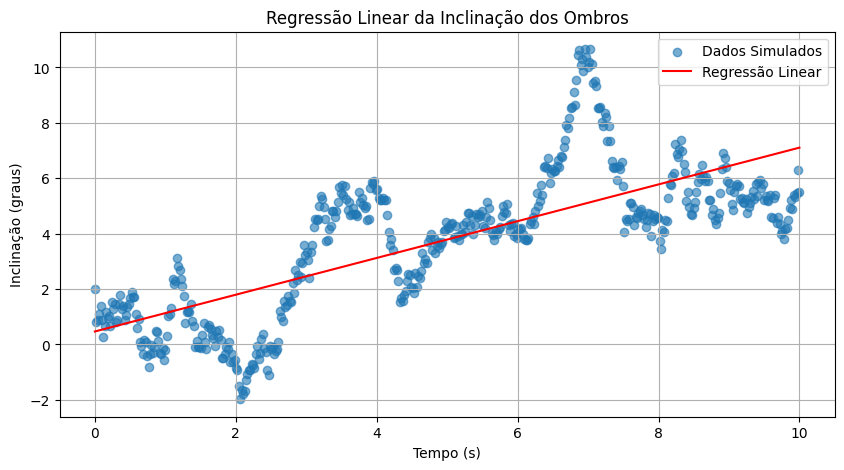


--- Métricas de Estabilidade ---
Desvio Médio Absoluto: 3.91°
Desvio Padrão: 2.59°
RMSE: 4.59°
Velocidade Angular Média: 15.93°/s
Velocidade Angular Máxima: 82.91°/s

--- Simulação RK4 Sem Otimização ---

--- Otimizando kp e kd ---


/var/folders/0_/xsgrtq815311pvnvyp40m0s40000gn/T/ipykernel_36799/2416843141.py:64: RuntimeWarning: overflow encountered in scalar divide
  domega_dt = (-kd * omega - kp * teta - torque_grav) / I
/var/folders/0_/xsgrtq815311pvnvyp40m0s40000gn/T/ipykernel_36799/2416843141.py:40: RuntimeWarning: invalid value encountered in add
  y[i+1] = y[i] + (k1 + 2*k2 + 2*k3 + k4)/6
/var/folders/0_/xsgrtq815311pvnvyp40m0s40000gn/T/ipykernel_36799/2416843141.py:62: RuntimeWarning: invalid value encountered in sin
  torque_grav = -m * g * l * np.sin(teta)
/var/folders/0_/xsgrtq815311pvnvyp40m0s40000gn/T/ipykernel_36799/2416843141.py:69: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean((ang_sim_deg - dados_reais) ** 2))
/var/folders/0_/xsgrtq815311pvnvyp40m0s40000gn/T/ipykernel_36799/2416843141.py:64: RuntimeWarning: overflow encountered in scalar multiply
  domega_dt = (-kd * omega - kp * teta - torque_grav) / I
/var/folders/0_/xsgrtq815311pvnvyp40m0s40000gn/T/ipykernel_36799/241

Parâmetros Otimizados: kp = -6072549.0196, kd = -19254.0916


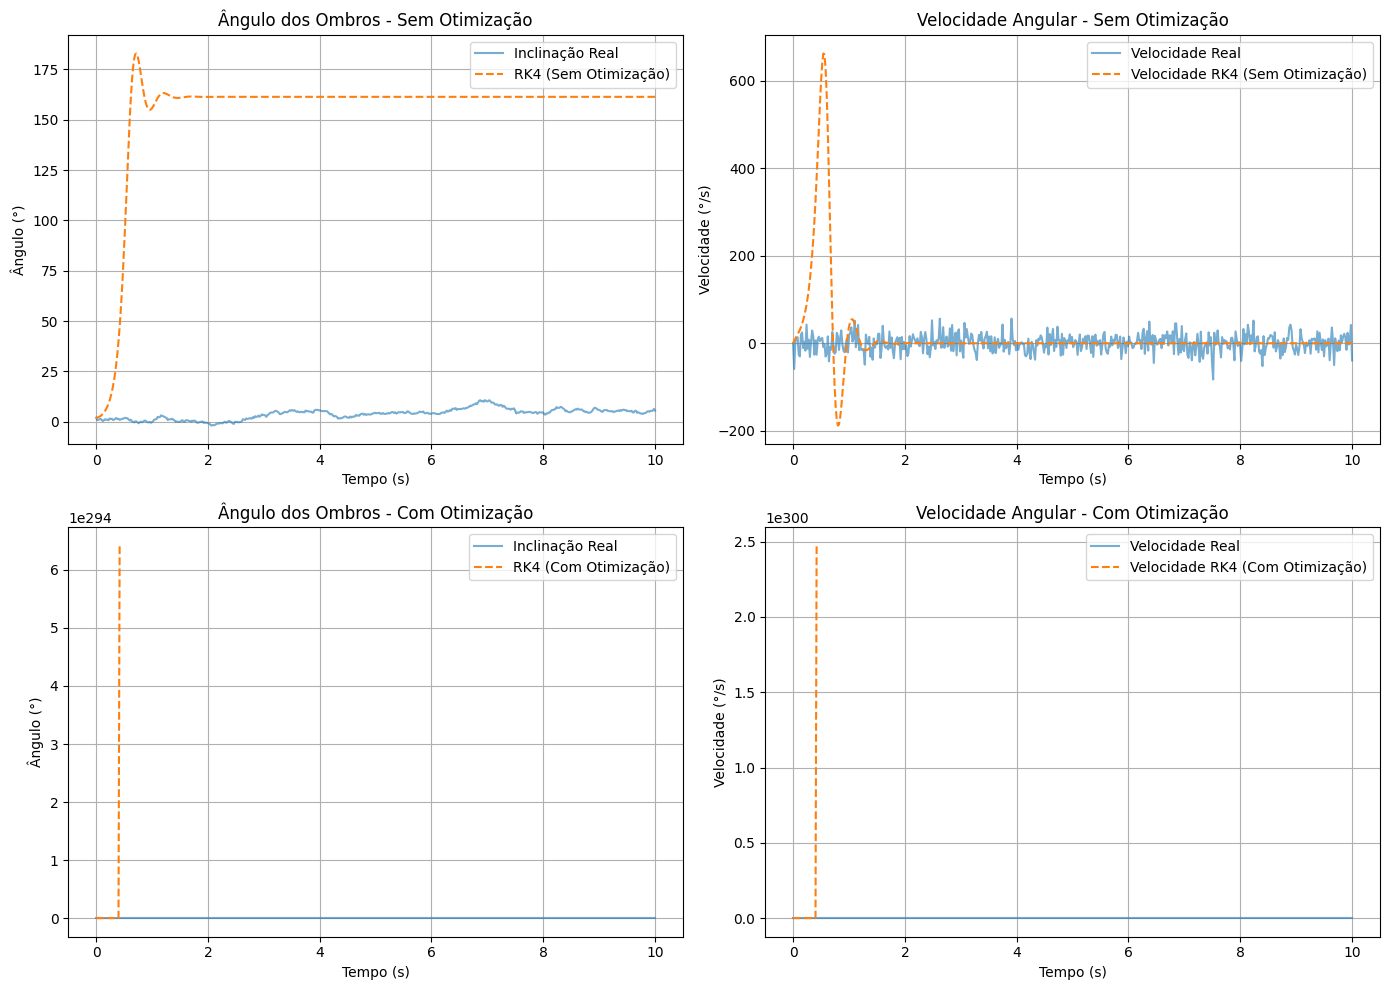

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# --- Geração Realista de Dados para facilitar a inserção de muitos arquivos do Sensor logger para análise ---
def generate_ombro_balance_durante_pirueta(duration=10, points=500):
    t = np.linspace(0, duration, points)
    tendencia_lenta = 4 * np.sin(2 * np.pi * t / duration + np.pi/4)
    ruido_irregular = np.cumsum(np.random.normal(0, 0.4, points))
    angulo_ombros = tendencia_lenta + ruido_irregular
    return pd.DataFrame({'Tempo': t, 'Graus_Angulo_Horizontal_Ombros': angulo_ombros})

# --- Regressão Linear ---
def regressao_linear(df, x_col, y_col):
    X = df[[x_col]].values
    y = df[y_col].values
    modelo = LinearRegression().fit(X, y)
    y_pred = modelo.predict(X)
    relatorio = (
        f"Coeficiente Angular: {modelo.coef_[0]:.4f}\n"
        f"Intercepto: {modelo.intercept_:.4f}\n"
        f"R²: {modelo.score(X, y):.4f}"
    )
    return modelo, y_pred, relatorio

# --- Método Runge-Kutta 4ª Ordem ---
def metodo_runge_kutta_sistemas_4ordem(f, y0, t):
    n = len(t)
    m = len(y0)
    y = np.zeros((n, m))
    y[0] = y0
    h = t[1] - t[0]
    for i in range(n - 1):
        k1 = h * f(y[i], t[i])
        k2 = h * f(y[i] + k1/2, t[i] + h/2)
        k3 = h * f(y[i] + k2/2, t[i] + h/2)
        k4 = h * f(y[i] + k3, t[i] + h)
        y[i+1] = y[i] + (k1 + 2*k2 + 2*k3 + k4)/6
    return y

# --- Sistema de EDOs sem otimização ---
def sistema_edo_equilibro_ombro(y, t):
    teta, omega = y
    I, kp, kd, m, l, g = 0.05, 1.0, 0.5, 3.0, 0.3, 9.81
    torque_grav = -m * g * l * np.sin(teta)
    dteta_dt = omega
    domega_dt = (-kd * omega - kp * teta - torque_grav) / I
    return np.array([dteta_dt, domega_dt])

# --- Função de custo para otimização ---
def funcao_custo(params, t, dados_reais):
    kp, kd = params
    ang0 = np.radians(dados_reais[0])
    omega0 = 0.0
    y0 = np.array([ang0, omega0])

    def sistema(y, _):
        teta, omega = y
        I, m, l, g = 0.05, 3.0, 0.3, 9.81
        torque_grav = -m * g * l * np.sin(teta)
        dteta_dt = omega
        domega_dt = (-kd * omega - kp * teta - torque_grav) / I
        return np.array([dteta_dt, domega_dt])

    y_simulado = metodo_runge_kutta_sistemas_4ordem(sistema, y0, t)
    ang_sim_deg = np.degrees(y_simulado[:, 0])
    return np.sqrt(np.mean((ang_sim_deg - dados_reais) ** 2))

# --- Função Principal ---
def main():
    df = generate_ombro_balance_durante_pirueta()
    print("\n--- Dados Simulados ---")
    print(df.head())

    tempo = df['Tempo'].values
    angulo = df['Graus_Angulo_Horizontal_Ombros'].values

    print("\n--- Regressão Linear ---")
    _, y_pred, relatorio = regressao_linear(df, 'Tempo', 'Graus_Angulo_Horizontal_Ombros')
    print(relatorio)

    plt.figure(figsize=(10, 5))
    plt.scatter(tempo, angulo, label="Dados Simulados", alpha=0.6)
    plt.plot(tempo, y_pred, color='red', label="Regressão Linear")
    plt.title("Regressão Linear da Inclinação dos Ombros")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Inclinação (graus)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Métricas de Estabilidade ---")
    desvio_abs = np.abs(angulo)
    print(f"Desvio Médio Absoluto: {np.mean(desvio_abs):.2f}°")
    print(f"Desvio Padrão: {np.std(angulo):.2f}°")
    print(f"RMSE: {np.sqrt(np.mean((angulo)**2)):.2f}°")

    velocidade_angular = np.insert(np.diff(angulo) / np.diff(tempo), 0, 0)
    print(f"Velocidade Angular Média: {np.mean(np.abs(velocidade_angular)):.2f}°/s")
    print(f"Velocidade Angular Máxima: {np.max(np.abs(velocidade_angular)):.2f}°/s")

    print("\n--- Simulação RK4 Sem Otimização ---")
    y0 = np.array([np.radians(angulo[0]), np.radians(velocidade_angular[0])])
    solucao_sem_otim = metodo_runge_kutta_sistemas_4ordem(sistema_edo_equilibro_ombro, y0, tempo)

    print("\n--- Otimizando kp e kd ---")
    resultado = minimize(funcao_custo, [1.0, 0.5], args=(tempo, angulo))
    kp_otim, kd_otim = resultado.x
    print(f"Parâmetros Otimizados: kp = {kp_otim:.4f}, kd = {kd_otim:.4f}")

    def sistema_otimizado(y, _):
        teta, omega = y
        I, m, l, g = 0.05, 3.0, 0.3, 9.81
        torque_grav = -m * g * l * np.sin(teta)
        dteta_dt = omega
        domega_dt = (-kd_otim * omega - kp_otim * teta - torque_grav) / I
        return np.array([dteta_dt, domega_dt])

    y0_otim = np.array([np.radians(angulo[0]), 0.0])
    solucao_otim = metodo_runge_kutta_sistemas_4ordem(sistema_otimizado, y0_otim, tempo)

    velocidade_modelo_sem_otim = np.degrees(solucao_sem_otim[:, 1])
    velocidade_modelo_otim = np.degrees(solucao_otim[:, 1])

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(tempo, angulo, label="Inclinação Real", alpha=0.6)
    plt.plot(tempo, np.degrees(solucao_sem_otim[:, 0]), '--', label="RK4 (Sem Otimização)")
    plt.title("Ângulo dos Ombros - Sem Otimização")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Ângulo (°)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(tempo, velocidade_angular, label="Velocidade Real", alpha=0.6)
    plt.plot(tempo, velocidade_modelo_sem_otim, '--', label="Velocidade RK4 (Sem Otimização)")
    plt.title("Velocidade Angular - Sem Otimização")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Velocidade (°/s)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(tempo, angulo, label="Inclinação Real", alpha=0.6)
    plt.plot(tempo, np.degrees(solucao_otim[:, 0]), '--', label="RK4 (Com Otimização)")
    plt.title("Ângulo dos Ombros - Com Otimização")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Ângulo (°)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(tempo, velocidade_angular, label="Velocidade Real", alpha=0.6)
    plt.plot(tempo, velocidade_modelo_otim, '--', label="Velocidade RK4 (Com Otimização)")
    plt.title("Velocidade Angular - Com Otimização")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Velocidade (°/s)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("comparacao_modelos_rk4.png", dpi=300)
    plt.show()

# --- Executar ---
if __name__ == "__main__":
    main()